
Key Findings:
Total State Changes: 102

Throughput Statistics (Mbps):
count    502.000000
mean       0.018605
std        0.032968
min        0.000000
25%        0.000000
50%        0.006023
75%        0.028746
max        0.366607
Name: downlink_mbps, dtype: float64

Ping Statistics (ms):
count    502.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: pop_ping_latency_ms, dtype: float64

Obstruction Ratio: 63.71%


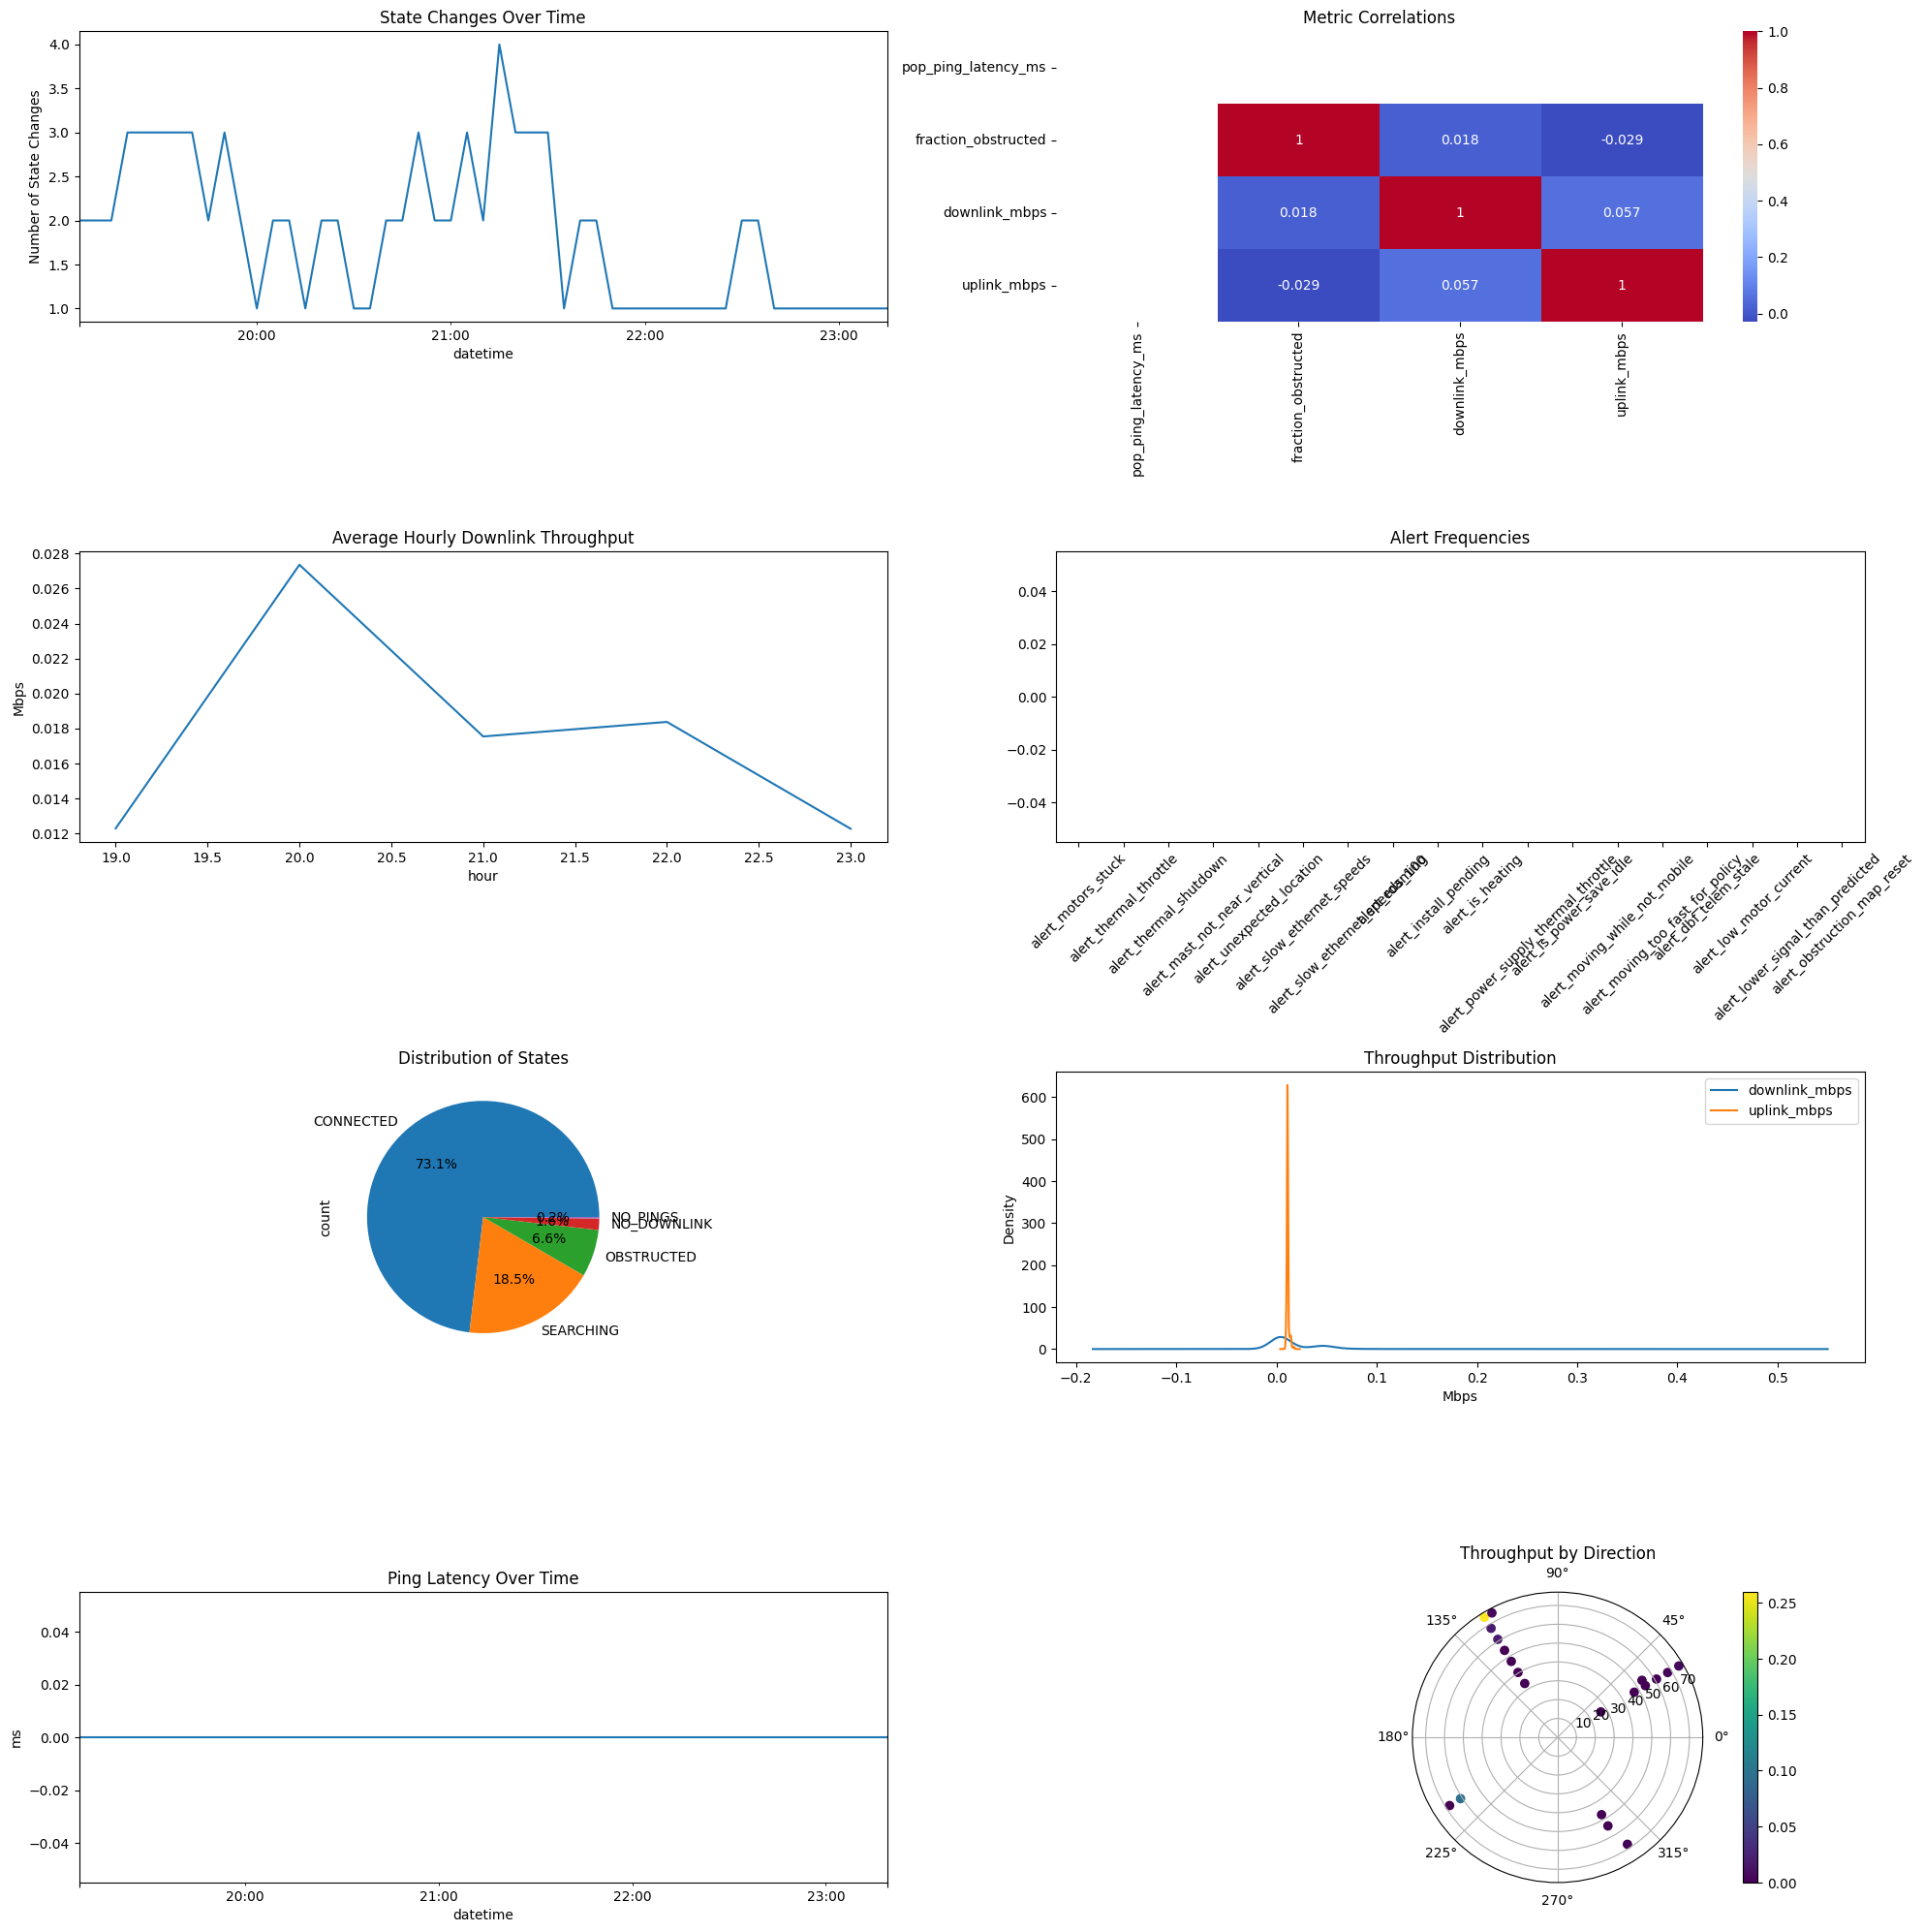

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

class StarlinkAnalyzer:
    def __init__(self, filepath):
        self.raw_df = pd.read_csv(filepath)
        self.df = self.preprocess_data()

    def preprocess_data(self):
        """Preprocess the data with proper datetime handling"""
        df = self.raw_df.copy()

        # Convert time to datetime
        df['datetime'] = pd.to_datetime(df['time'], unit='s')
        df.set_index('datetime', inplace=True)

        # Extract time components
        df['hour'] = df.index.hour
        df['minute'] = df.index.minute
        df['day'] = df.index.day

        # Handle missing values
        df['pop_ping_latency_ms'] = df['pop_ping_latency_ms'].fillna(df['pop_ping_latency_ms'].mean())
        df['snr'] = df['snr'].fillna(df['snr'].mean())

        # Convert throughputs to Mbps
        df['downlink_mbps'] = df['downlink_throughput_bps'] / 1e6
        df['uplink_mbps'] = df['uplink_throughput_bps'] / 1e6

        return df

    def analyze_handovers(self):
        """Analyze state transitions and handovers"""
        # Basic state transition analysis
        state_changes = self.df['state'].ne(self.df['state'].shift()).sum()
        state_durations = self.df.groupby('state').size().reset_index(name='count')

        # Calculate average duration for each state
        durations = []
        for state in state_durations['state']:
            state_times = self.df[self.df['state'] == state].index
            avg_duration = state_times.to_series().diff().mean().total_seconds()
            durations.append(avg_duration)
        state_durations['avg_duration'] = durations

        # Time series of state changes (using 5min intervals)
        state_changes_ts = self.df['state'].resample('5min').nunique()

        # Analyze patterns in state changes
        hourly_changes = self.df.groupby('hour')['state'].nunique()

        return {
            'total_changes': state_changes,
            'state_durations': state_durations,
            'time_series': state_changes_ts,
            'hourly_pattern': hourly_changes
        }

    def analyze_connection_quality(self):
        """Analyze connection quality metrics"""
        # Basic metrics
        metrics = {
            'snr_stats': self.df['snr'].describe(),
            'obstruction_ratio': self.df['fraction_obstructed'].mean(),
            'ping_stats': self.df['pop_ping_latency_ms'].describe(),
            'ping_drop_rate': self.df['pop_ping_drop_rate'].mean()
        }

        # Hourly patterns
        hourly_metrics = self.df.groupby('hour').agg({
            'pop_ping_latency_ms': ['mean', 'std'],
            'fraction_obstructed': 'mean',
            'pop_ping_drop_rate': 'mean'
        })

        # Correlation analysis
        corr_matrix = self.df[[
            'pop_ping_latency_ms', 'fraction_obstructed',
            'downlink_mbps', 'uplink_mbps'
        ]].corr()

        return metrics, hourly_metrics, corr_matrix

    def analyze_throughput(self):
        """Analyze throughput performance"""
        # Basic statistics
        stats = {
            'downlink': self.df['downlink_mbps'].describe(),
            'uplink': self.df['uplink_mbps'].describe()
        }

        # Hourly patterns
        hourly_throughput = self.df.groupby('hour').agg({
            'downlink_mbps': ['mean', 'std'],
            'uplink_mbps': ['mean', 'std']
        })

        # Stability analysis
        stats['downlink_cv'] = self.df['downlink_mbps'].std() / self.df['downlink_mbps'].mean()
        stats['uplink_cv'] = self.df['uplink_mbps'].std() / self.df['uplink_mbps'].mean()

        # Performance clustering
        X = self.df[['downlink_mbps', 'uplink_mbps']].dropna()
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        kmeans = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)

        return stats, hourly_throughput, clusters

    def analyze_alerts(self):
        """Analyze system alerts"""
        alert_columns = [col for col in self.df.columns if col.startswith('alert_')]
        alert_stats = self.df[alert_columns].sum()

        # Hourly alert patterns
        alert_ts = self.df[alert_columns].resample('1h').sum()

        # Impact analysis
        alert_impact = pd.DataFrame()
        for alert in alert_columns:
            if self.df[alert].sum() > 0:  # Only analyze alerts that occurred
                impact = {
                    'downlink_impact': self.df[self.df[alert]]['downlink_mbps'].mean() / \
                                     self.df[~self.df[alert]]['downlink_mbps'].mean(),
                    'latency_impact': self.df[self.df[alert]]['pop_ping_latency_ms'].mean() / \
                                    self.df[~self.df[alert]]['pop_ping_latency_ms'].mean()
                }
                alert_impact[alert] = pd.Series(impact)

        return alert_stats, alert_ts, alert_impact

    def analyze_geographic_impact(self):
        """Analyze impact of dish direction"""
        # Only analyze rows with valid direction data
        direction_df = self.df[
            (self.df['direction_azimuth'] != 0) &
            (self.df['direction_elevation'] != 0)
        ]

        if len(direction_df) > 0:
            # Create bins for azimuth and elevation
            az_bins = np.linspace(
                direction_df['direction_azimuth'].min(),
                direction_df['direction_azimuth'].max(),
                9
            )
            el_bins = np.linspace(
                direction_df['direction_elevation'].min(),
                direction_df['direction_elevation'].max(),
                9
            )

            # Bin the data
            direction_df['az_bin'] = pd.cut(direction_df['direction_azimuth'], az_bins)
            direction_df['el_bin'] = pd.cut(direction_df['direction_elevation'], el_bins)

            # Direction impact analysis
            direction_impact = direction_df.groupby(['az_bin', 'el_bin'], observed=True).agg({
                'downlink_mbps': 'mean',
                'pop_ping_latency_ms': 'mean',
                'fraction_obstructed': 'mean'
            }).reset_index()

            # For plotting, use bin midpoints
            direction_impact['azimuth'] = direction_impact['az_bin'].apply(lambda x: x.mid)
            direction_impact['elevation'] = direction_impact['el_bin'].apply(lambda x: x.mid)

            # Elevation analysis
            elevation_analysis = direction_df.groupby('el_bin', observed=True).agg({
                'downlink_mbps': ['mean', 'std'],
                'pop_ping_latency_ms': ['mean', 'std']
            })

            return direction_impact, elevation_analysis
        else:
            return None, None

    def generate_report(self):
        """Generate comprehensive analysis visualization"""
        fig = plt.figure(figsize=(20, 25))

        # 1. State Analysis
        handover_stats = self.analyze_handovers()
        ax1 = plt.subplot(5, 2, 1)
        handover_stats['time_series'].plot(ax=ax1)
        ax1.set_title('State Changes Over Time')
        ax1.set_ylabel('Number of State Changes')

        # 2. Connection Quality
        metrics, hourly_metrics, corr_matrix = self.analyze_connection_quality()
        ax2 = plt.subplot(5, 2, 2)
        sns.heatmap(corr_matrix, annot=True, ax=ax2, cmap='coolwarm')
        ax2.set_title('Metric Correlations')

        # 3. Throughput Analysis
        stats, hourly_throughput, clusters = self.analyze_throughput()
        ax3 = plt.subplot(5, 2, 3)
        hourly_throughput['downlink_mbps']['mean'].plot(ax=ax3)
        ax3.set_title('Average Hourly Downlink Throughput')
        ax3.set_ylabel('Mbps')

        # 4. Alerts
        alert_stats, alert_ts, alert_impact = self.analyze_alerts()
        ax4 = plt.subplot(5, 2, 4)
        alert_stats.plot(kind='bar', ax=ax4)
        ax4.set_title('Alert Frequencies')
        plt.xticks(rotation=45)

        # 5. State Distribution
        ax5 = plt.subplot(5, 2, 5)
        self.df['state'].value_counts().plot(kind='pie', ax=ax5, autopct='%1.1f%%')
        ax5.set_title('Distribution of States')

        # 6. Throughput Distribution
        ax6 = plt.subplot(5, 2, 6)
        self.df[['downlink_mbps', 'uplink_mbps']].plot(
            kind='kde', ax=ax6
        )
        ax6.set_title('Throughput Distribution')
        ax6.set_xlabel('Mbps')

        # 7. Ping Latency Over Time
        ax7 = plt.subplot(5, 2, 7)
        self.df['pop_ping_latency_ms'].plot(ax=ax7)
        ax7.set_title('Ping Latency Over Time')
        ax7.set_ylabel('ms')

        # 8. Geographic Analysis
        direction_impact, elevation_analysis = self.analyze_geographic_impact()
        if direction_impact is not None:
            ax8 = plt.subplot(5, 2, 8, projection='polar')
            scatter = ax8.scatter(
                direction_impact['azimuth'],
                direction_impact['elevation'],
                c=direction_impact['downlink_mbps'],
                cmap='viridis'
            )
            plt.colorbar(scatter)
            ax8.set_title('Throughput by Direction')

        plt.tight_layout()
        return fig, {
            'handover_stats': handover_stats,
            'connection_metrics': metrics,
            'throughput_stats': stats,
            'alert_stats': alert_stats
        }

def main():
    analyzer = StarlinkAnalyzer('status_data.csv')
    fig, stats = analyzer.generate_report()

    # Print key findings
    print("\nKey Findings:")
    print(f"Total State Changes: {stats['handover_stats']['total_changes']}")
    print("\nThroughput Statistics (Mbps):")
    print(stats['throughput_stats']['downlink'])
    print("\nPing Statistics (ms):")
    print(stats['connection_metrics']['ping_stats'])
    print(f"\nObstruction Ratio: {stats['connection_metrics']['obstruction_ratio']:.2%}")

    return fig, stats

if __name__ == "__main__":
    main()


Advanced Analysis Results:

Quality of Service Scores:
overall_qos          0.363
latency_score        1.000
throughput_score     0.157
reliability_score    0.000
dtype: float64

Stability Metrics:
down_cv    1.772
up_cv      0.102
dtype: float64

Prediction Model Performance:
R² Score: 0.266


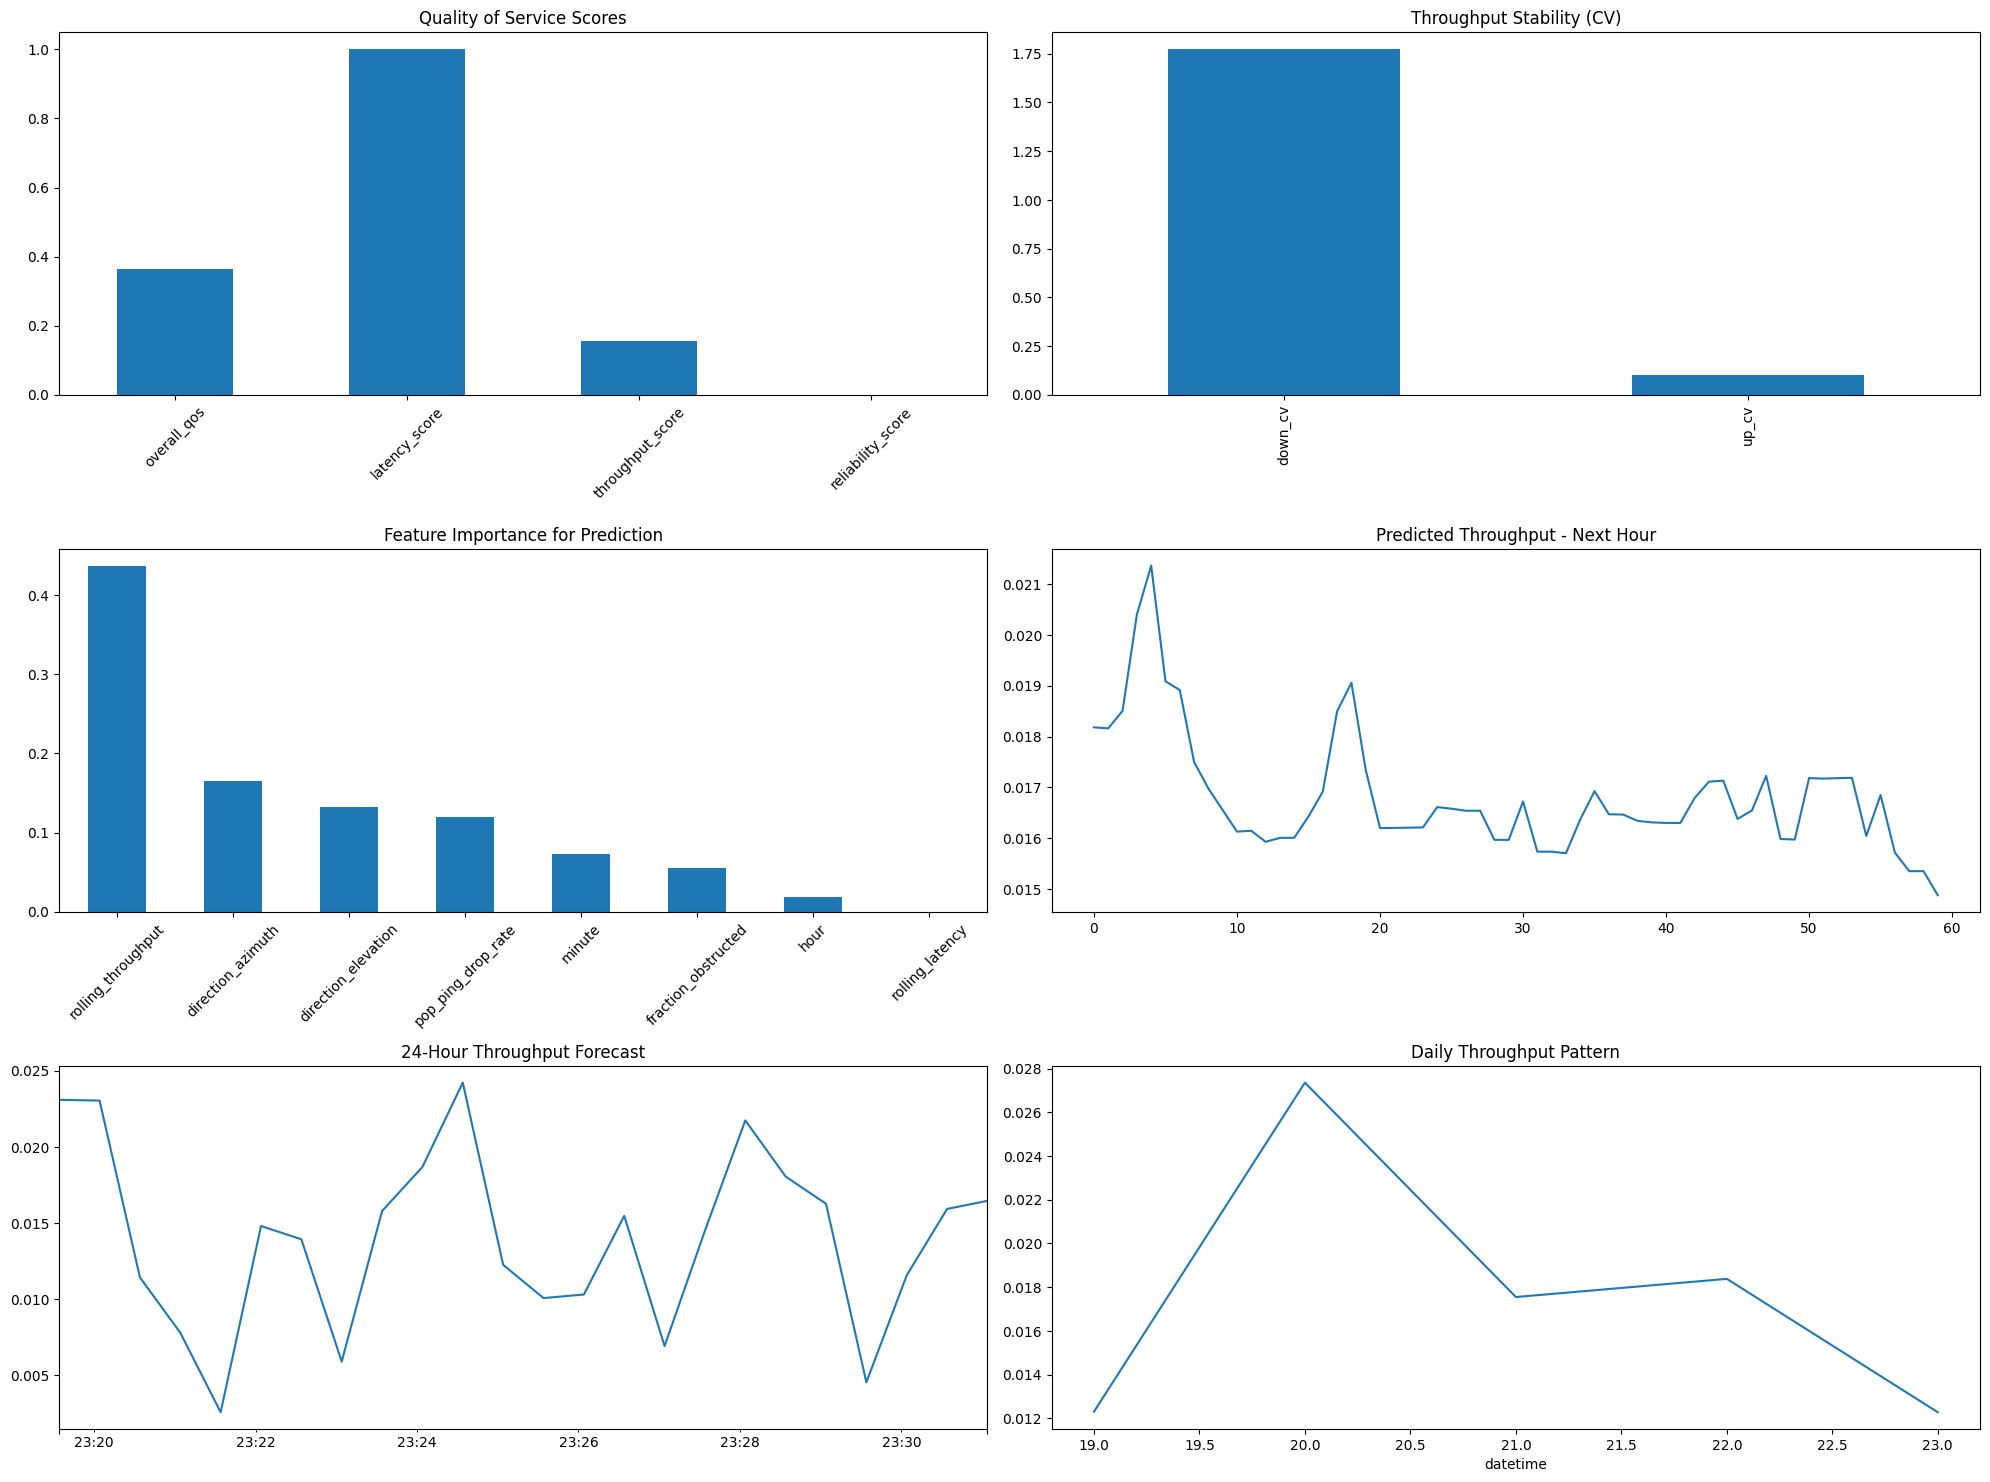

In [ ]:
 # [Previous imports and other classes remain the same until StarlinkAnalyzer]

class StarlinkAnalyzer:
    """Enhanced Starlink Data Analyzer with advanced features"""

    def __init__(self, filepath):
        self.raw_df = pd.read_csv(filepath)
        self.df = self.preprocess_data()

        # Initialize specialized analyzers
        self.qos_scorer = NetworkQoSScorer(self.df)
        self.stability_analyzer = NetworkStabilityAnalyzer(self.df)
        self.performance_predictor = PerformancePredictor(self.df)
        self.time_series_analyzer = TimeSeriesAnalyzer(self.df)

    def preprocess_data(self):
        """Preprocess the data with proper datetime handling"""
        df = self.raw_df.copy()

        # Convert time to datetime
        df['datetime'] = pd.to_datetime(df['time'], unit='s')
        df.set_index('datetime', inplace=True)

        # Extract time components
        df['hour'] = df.index.hour
        df['minute'] = df.index.minute
        df['day'] = df.index.day

        # Handle missing values
        df['pop_ping_latency_ms'] = df['pop_ping_latency_ms'].fillna(df['pop_ping_latency_ms'].mean())
        df['snr'] = df['snr'].fillna(df['snr'].mean())

        # Convert throughputs to Mbps
        df['downlink_mbps'] = df['downlink_throughput_bps'] / 1e6
        df['uplink_mbps'] = df['uplink_throughput_bps'] / 1e6

        # Calculate network jitter
        df['jitter'] = df['pop_ping_latency_ms'].diff().abs()

        # Calculate rolling metrics
        df['rolling_latency'] = df['pop_ping_latency_ms'].rolling(window=5, min_periods=1).mean()
        df['rolling_throughput'] = df['downlink_mbps'].rolling(window=5, min_periods=1).mean()
        df['rolling_drop_rate'] = df['pop_ping_drop_rate'].rolling(window=5, min_periods=1).mean()

        # Calculate connection stability metrics
        df['state_changed'] = df['state'].ne(df['state'].shift()).astype(int)
        df['connected'] = (df['state'] == 'CONNECTED').astype(int)

        return df

    def analyze_handovers(self):
        """Analyze state transitions and handovers"""
        # Basic state transition analysis
        state_changes = self.df['state'].ne(self.df['state'].shift()).sum()
        state_durations = self.df.groupby('state').size().reset_index(name='count')

        # Calculate average duration for each state
        durations = []
        for state in state_durations['state']:
            state_times = self.df[self.df['state'] == state].index
            avg_duration = state_times.to_series().diff().mean().total_seconds()
            durations.append(avg_duration)
        state_durations['avg_duration'] = durations

        # Time series of state changes
        state_changes_ts = self.df['state'].resample('5min').nunique()

        # Analyze patterns in state changes
        hourly_changes = self.df.groupby('hour')['state'].nunique()

        return {
            'total_changes': state_changes,
            'state_durations': state_durations,
            'time_series': state_changes_ts,
            'hourly_pattern': hourly_changes
        }

    def analyze_connection_quality(self):
        """Analyze connection quality metrics"""
        # Basic metrics
        metrics = {
            'snr_stats': self.df['snr'].describe(),
            'obstruction_ratio': self.df['fraction_obstructed'].mean(),
            'ping_stats': self.df['pop_ping_latency_ms'].describe(),
            'ping_drop_rate': self.df['pop_ping_drop_rate'].mean()
        }

        # Hourly patterns
        hourly_metrics = self.df.groupby('hour').agg({
            'pop_ping_latency_ms': ['mean', 'std'],
            'fraction_obstructed': 'mean',
            'pop_ping_drop_rate': 'mean'
        })

        # Correlation analysis
        corr_matrix = self.df[[
            'pop_ping_latency_ms', 'fraction_obstructed',
            'downlink_mbps', 'uplink_mbps'
        ]].corr()

        return metrics, hourly_metrics, corr_matrix

    def analyze_throughput(self):
        """Analyze throughput performance"""
        # Basic statistics
        stats = {
            'downlink': self.df['downlink_mbps'].describe(),
            'uplink': self.df['uplink_mbps'].describe()
        }

        # Hourly patterns
        hourly_throughput = self.df.groupby('hour').agg({
            'downlink_mbps': ['mean', 'std'],
            'uplink_mbps': ['mean', 'std']
        })

        # Performance clustering
        X = self.df[['downlink_mbps', 'uplink_mbps']].dropna()
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        kmeans = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)

        return stats, hourly_throughput, clusters

    def analyze_advanced_metrics(self):
        """Run advanced analysis"""
        # QoS Analysis
        qos_scores = self.qos_scorer.calculate_overall_qos()

        # Stability Analysis
        stability_metrics = self.stability_analyzer.get_stability_metrics()

        # Performance Prediction
        prediction_metrics = self.performance_predictor.train_throughput_predictor()
        next_hour_prediction = self.performance_predictor.predict_next_hour()

        # Time Series Analysis
        throughput_forecast = self.time_series_analyzer.forecast_metric('downlink_mbps')
        time_patterns = self.time_series_analyzer.get_time_patterns()

        return {
            'qos_scores': qos_scores,
            'stability_metrics': stability_metrics,
            'prediction_metrics': prediction_metrics,
            'next_hour_prediction': next_hour_prediction,
            'throughput_forecast': throughput_forecast,
            'time_patterns': time_patterns
        }

    def generate_advanced_report(self):
        """Generate comprehensive report with advanced metrics"""
        fig = plt.figure(figsize=(20, 30))

        # Get advanced metrics
        advanced_metrics = self.analyze_advanced_metrics()

        # 1. QoS Scores
        ax1 = plt.subplot(6, 2, 1)
        qos_scores = pd.Series(advanced_metrics['qos_scores'])
        qos_scores.plot(kind='bar', ax=ax1)
        ax1.set_title('Quality of Service Scores')
        plt.xticks(rotation=45)

        # 2. Stability Metrics
        ax2 = plt.subplot(6, 2, 2)
        stability = advanced_metrics['stability_metrics']['throughput_stability']
        pd.Series(stability).plot(kind='bar', ax=ax2)
        ax2.set_title('Throughput Stability (CV)')

        # 3. Feature Importance
        ax3 = plt.subplot(6, 2, 3)
        advanced_metrics['prediction_metrics']['feature_importance'].plot(
            kind='bar', ax=ax3
        )
        ax3.set_title('Feature Importance for Prediction')
        plt.xticks(rotation=45)

        # 4. Next Hour Prediction
        ax4 = plt.subplot(6, 2, 4)
        advanced_metrics['next_hour_prediction'].plot(ax=ax4)
        ax4.set_title('Predicted Throughput - Next Hour')

        # 5. Throughput Forecast
        if advanced_metrics['throughput_forecast'] is not None:
            ax5 = plt.subplot(6, 2, 5)
            advanced_metrics['throughput_forecast'].plot(ax=ax5)
            ax5.set_title('24-Hour Throughput Forecast')

        # 6. Time Patterns
        ax6 = plt.subplot(6, 2, 6)
        advanced_metrics['time_patterns']['downlink_mbps']['mean'].plot(ax=ax6)
        ax6.set_title('Daily Throughput Pattern')

        plt.tight_layout()
        return fig, advanced_metrics

def main():
    analyzer = StarlinkAnalyzer('status_data.csv')
    fig, metrics = analyzer.generate_advanced_report()

    # Print advanced findings
    print("\nAdvanced Analysis Results:")
    print("\nQuality of Service Scores:")
    print(pd.Series(metrics['qos_scores']).round(3))

    print("\nStability Metrics:")
    print(pd.Series(metrics['stability_metrics']['throughput_stability']).round(3))

    print("\nPrediction Model Performance:")
    print(f"R² Score: {metrics['prediction_metrics']['test_score']:.3f}")

    return fig, metrics

if __name__ == "__main__":
    main()